In [1]:
%reload_ext autoreload
%autoreload 2
import os, sys
sys.path.append('..')

from tqdm.notebook import tqdm
import pickle

import numpy as np
import healpy as hp
import scipy.interpolate as interpolate
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord

import jax.numpy as jnp
from jax import jit, vmap

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../matplotlibrc')

In [2]:
from utils.units_constants import *
from utils.spectral import *
from utils.nfw import *
from utils.map_utils import *
from utils.snr import *

In [3]:
INTM_DIR = '../data/CHIME_estimate_intermediates'

## 1. Galactic longitude l and latitude b

In [4]:
CHIME_pixel_size = 15 * arcmin # rad

n_b_pix = int(jnp.round(jnp.pi/CHIME_pixel_size))
n_l_pix = int(jnp.round(2*jnp.pi/CHIME_pixel_size))
b_edge_s = jnp.linspace(-jnp.pi/2, jnp.pi/2, n_b_pix+1)
l_edge_s = jnp.linspace(-jnp.pi, jnp.pi, n_l_pix+1)
b_s = (b_edge_s[:-1] + b_edge_s[1:]) / 2 # bin centers
l_s = (l_edge_s[:-1] + l_edge_s[1:]) / 2 # bin centers

l_grid, b_grid = jnp.meshgrid(l_s, b_s)
lb_flat = jnp.stack([l_grid.flatten(), b_grid.flatten()], axis=-1)

## 2. Source (Haslam) map

In [6]:
nu_haslam = 408 # [MHz]
haslam_dsds_map_hp = hp.read_map('../data/haslam_maps/haslam408_dsds_Remazeilles2014.fits')
haslam_dsds_map = hp.pixelfunc.get_interp_val(haslam_dsds_map_hp, l_grid/deg, b_grid/deg, lonlat=True)

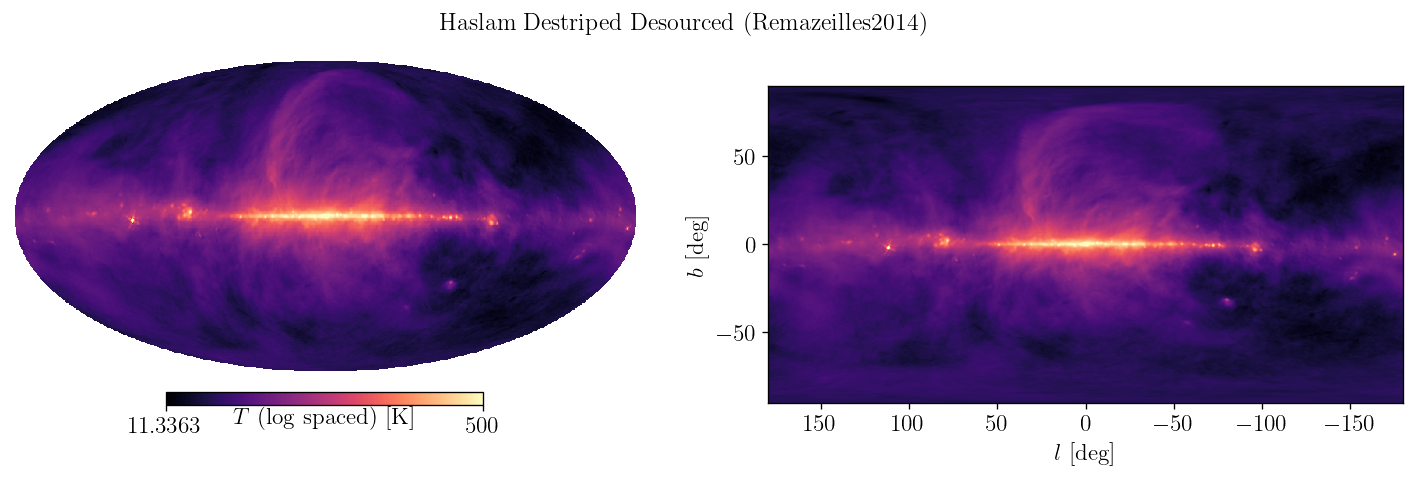

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(15,4))

plt.axes(axs[0])
hp.mollview(haslam_dsds_map_hp, norm='log', unit=r'$T$ (log spaced) [K]', title='',
            cmap='magma', max=500, hold=True)
im = axs[1].imshow(np.flip(np.log10(haslam_dsds_map)), cmap='magma', vmax=np.log10(500),
              extent=(180, -180, -90, 90))
axs[1].set(xlabel=r'$l$ [deg]', ylabel=r'$b$ [deg]', aspect=1)
#fig.colorbar(im, ax=axs[1], shrink=0.8)

fig.suptitle('Haslam Destriped Desourced (Remazeilles2014)');

## 2. DM column integral

In [8]:
rho_integral_map = rho_integral(lb_flat).reshape(n_b_pix, n_l_pix)

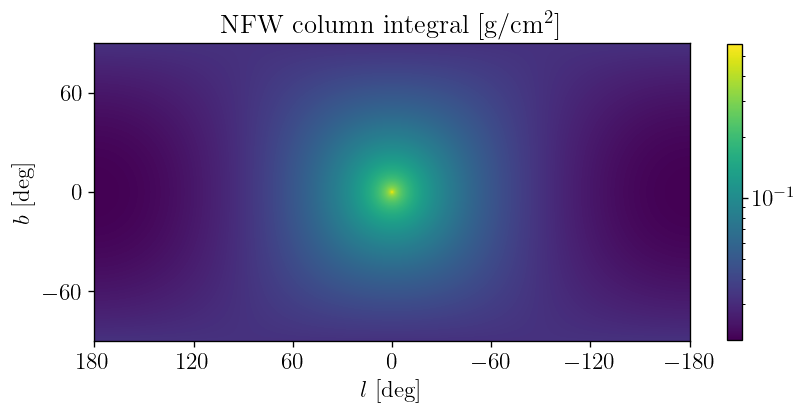

In [9]:
plot_lb(rho_integral_map, title=r'NFW column integral [g/cm$^2$]', cmap='viridis')

In [10]:
print(rho_integral_ref, '[g/cm^2]')

0.025303455 [g/cm^2]


## 3. Gegenschein temperature

Gegenschein intensity:
$$I_g=\hbar c^4\frac{g^2}{16}I_{\nu,0}\int\rho.$$
Specific intensity in interested frequency range:
$$I_{\nu,g}=\frac{f_\Delta}{\Delta\nu}\hbar c^4\frac{g^2}{16}I_{\nu,0}\int\rho.$$
Temperature
$$T_g=\frac{f_\Delta}{\Delta\nu}\hbar c^4\frac{g^2}{16}T_0\int\rho=\text{prefac}\cdot T_0\cdot \int\rho.$$
dimensions:
$$\text{[K]}=\frac{[1]}{\text{[MHz]}}\text{[cm}^2\text{ MHz GeV]}(\hbar c^2)\frac{[1]}{\text{[GeV]}^2}\text{[K]}\frac{\text{[GeV]}}{\text{[cm]}^2}(\int\rho c^2).$$

In [11]:
# antipodal Haslam map
haslam_anti_dsds_map = antipodal_lb_map(haslam_dsds_map)

# naive (reference) gegenschein temperature
gegen_temp_map = prefac(nu_haslam) * haslam_anti_dsds_map * rho_integral_map

# reference forward+front temperature # I_src * 10kpc uniform column with rho_NFW(r_Sun)
forward_temp_map = prefac(nu_haslam) * haslam_dsds_map * rho_integral_ref

In [12]:
np.save(f'{INTM_DIR}/gegen_temp_map.npy', gegen_temp_map)
np.save(f'{INTM_DIR}/forward_temp_map.npy', forward_temp_map)
np.save(f'{INTM_DIR}/haslam_dsds_map.npy', haslam_dsds_map)

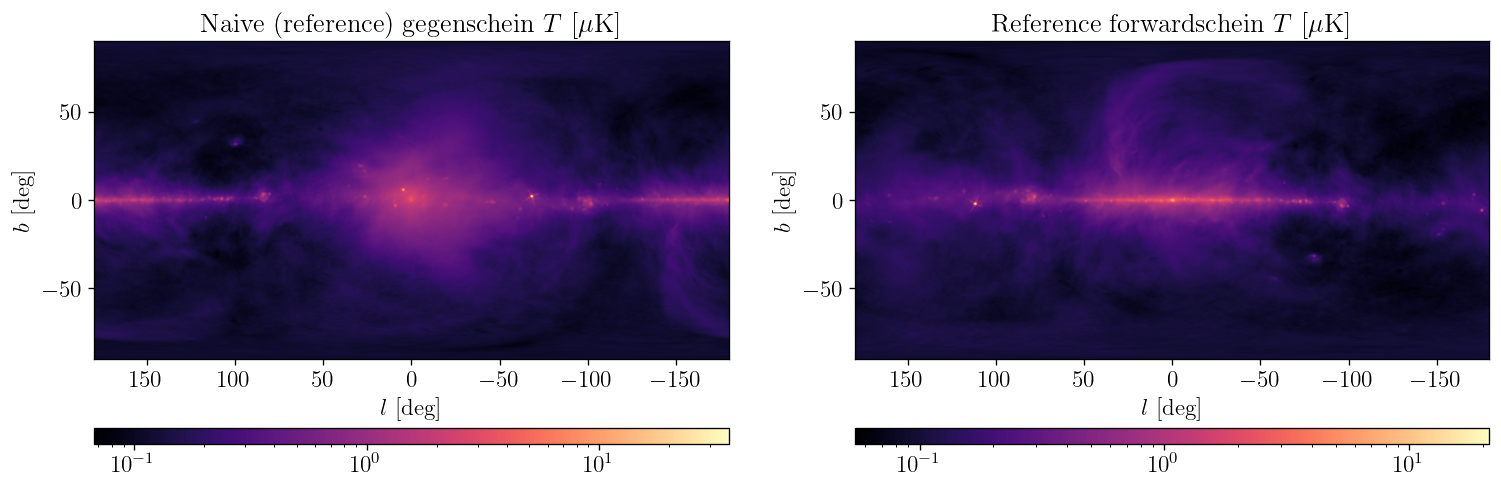

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))

z = gegen_temp_map * 1e6
im0 = axs[0].imshow(np.flip(z), cmap='magma', extent=(180, -180, -90, 90),
                    norm=mpl.colors.LogNorm(np.min(z), np.max(z)))
z = forward_temp_map * 1e6
im1 = axs[1].imshow(np.flip(z), cmap='magma', extent=(180, -180, -90, 90),
                    norm=mpl.colors.LogNorm(np.min(z), np.max(z)))
axs[0].set(title=r'Naive (reference) gegenschein $T$ [$\mu$K]', xlabel=r'$l$ [deg]', ylabel=r'$b$ [deg]')
axs[1].set(title=r'Reference forwardschein $T$ [$\mu$K]', xlabel=r'$l$ [deg]', ylabel=r'$b$ [deg]')
fig.colorbar(im0, ax=axs[0], orientation='horizontal', aspect=40)
fig.colorbar(im1, ax=axs[1], orientation='horizontal', aspect=40);

## 4. Exposure

In [14]:
t_baseline = 600 # [s]
double_pass_dec = np.deg2rad(70)

def exposure(dec):
    """Exposure time [s] as a function of dec [rad]. dec can be a vector."""
    return ((dec > double_pass_dec) + 1) * t_baseline / jnp.abs(jnp.cos(dec)) * (dec > jnp.deg2rad(-20))

def icrs_dec(lb):
    """ICRS declination [rad] from galactic lb [(rad, rad)]. Vectorized manually."""
    c_NGP = SkyCoord(l=0*u.deg, b=90*u.deg, frame='galactic') # north galactic pole
    c_NCP = SkyCoord(ra=0*u.deg, dec=90*u.deg, frame='icrs') # north celestial pole
    dec_NGP = float(c_NGP.icrs.dec/u.rad)
    l_NCP = float(c_NCP.galactic.l/u.rad)
    
    l, b = lb[:,0], lb[:,1]
    return jnp.arcsin(jnp.sin(dec_NGP)*jnp.sin(b) + jnp.cos(dec_NGP)*jnp.cos(b)*jnp.cos(l_NCP-l))

In [15]:
exposure_map = exposure(icrs_dec(lb_flat)).reshape((n_b_pix, n_l_pix))

In [16]:
np.save(f'{INTM_DIR}/exposure_map.npy', exposure_map)

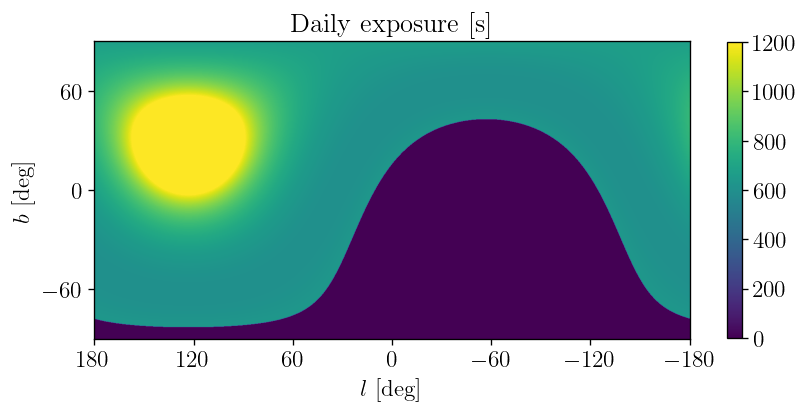

In [17]:
plot_lb(exposure_map, log_norm=False, title='Daily exposure [s]',
        vmax=1200, vmin=0, cmap='viridis')

## 5. S/N

$$S/N = \sqrt{\sum_i (S/N_i)^2}$$

$$S/N_i=\frac{T_{g,i}}{T_{\text{sys},i}}\sqrt{2\Delta\nu~t_\text{obs}}$$

In [18]:
n_day = 3.5 * 365

In [19]:
T_sys_map = 50 + haslam_dsds_map
SNR_g_s = gegen_temp_map * np.sqrt(2*dnu(408)*1e6*exposure_map*n_day) / T_sys_map
SNR_f_s = forward_temp_map * np.sqrt(2*dnu(408)*1e6*exposure_map*n_day) / T_sys_map
print('naive gegenschein:', np.sqrt(np.sum(SNR_g_s**2)))
print('reference forwardschein:', np.sqrt(np.sum(SNR_f_s**2)))

naive gegenschein: 1.870438
reference forwardschein: 1.2446418


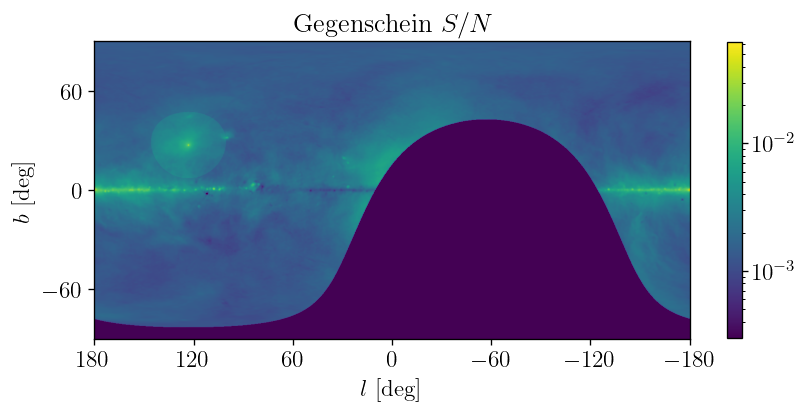

In [20]:
plot_lb(np.clip(SNR_g_s, 3e-4, None), title=r'Gegenschein $S/N$', cmap='viridis')

## 6. Modification according to 3D model

In [21]:
B_scheme = 'BS_H'

I_data = pickle.load(open(f'../data/galactic_models/I_data_{B_scheme}.dict', 'rb'))

In [22]:
g_ratio_lr = I_data['focused'] / I_data['naive']
f_ratio_lr = (I_data['front'] + I_data['forward']) / I_data['forward_ref']

g_ratio = padded_interpolator(I_data['l'], I_data['b'], g_ratio_lr)(l_s, b_s)
f_ratio = padded_interpolator(I_data['l'], I_data['b'], f_ratio_lr)(l_s, b_s)

tot_temp_map = gegen_temp_map * g_ratio + forward_temp_map * f_ratio
SNR_tot_map = tot_temp_map * np.sqrt(2*dnu(408)*1e6*exposure_map*n_day) / T_sys_map
print(f'{B_scheme} SNR = {np.sqrt(np.sum((SNR_tot_map)**2))}')

BS_H SNR = 3.439507484436035


In [23]:
np.save(f'{INTM_DIR}/tot_temp_map_{B_scheme}.npy', tot_temp_map)

## 7. Frequency dependence (no SNR)

In [24]:
tot_temp_map = {}
B_schemes = ['ASR_H', 'BS_H']
for B_scheme in B_schemes:
    tot_temp_map[B_scheme] = np.load(f'{INTM_DIR}/tot_temp_map_{B_scheme}.npy')
haslam_dsds_map = np.load(f'{INTM_DIR}/haslam_dsds_map.npy')
exposure_map = np.load(f'{INTM_DIR}/exposure_map.npy')

In [25]:
freq_s = np.linspace(400, 800, 30)
tot_SNR_s = {}
for B_scheme in B_schemes:
    tot_SNR_s[B_scheme] = np.zeros_like(freq_s)
    
beta = -2.55

for i, freq in enumerate(tqdm(freq_s)):
    for B_scheme in B_schemes:
        sig_temp_map = tot_temp_map[B_scheme] * (freq/nu_haslam)**(beta-1)
        bkg_temp_map = haslam_dsds_map * (freq/nu_haslam)**(beta) + 50
        SNR_map = sig_temp_map * np.sqrt(2*dnu(freq)*1e6*exposure_map*n_day) / bkg_temp_map
        tot_SNR_s[B_scheme][i] = np.sqrt(np.sum(SNR_map**2))

  0%|          | 0/30 [00:00<?, ?it/s]

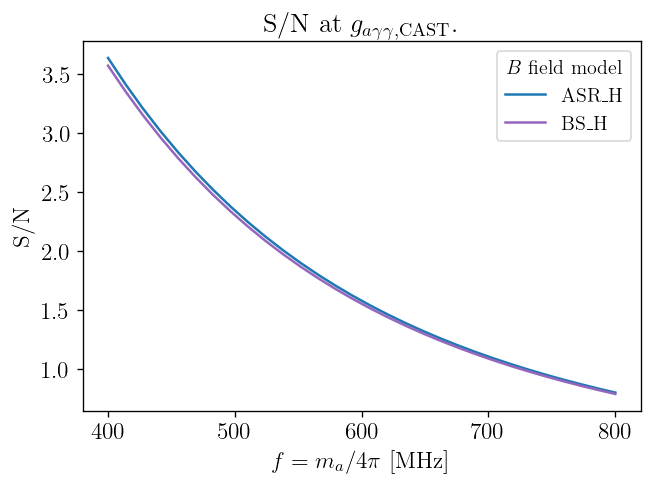

In [26]:
fig, ax = plt.subplots(figsize=(6, 4))

colors = ['tab:blue', 'tab:purple']

for i, B_scheme in enumerate(B_schemes):
    ax.plot(freq_s, tot_SNR_s[B_scheme], label=B_scheme, c=colors[i])
ax.set(xlabel=r'$f=m_a/4\pi$ [MHz]', ylabel='S/N',
       title=r'S/N at $g_{a\gamma\gamma,\mathrm{CAST}}$.')
ax.legend(title=r'$B$ field model');

## 8. Add SNRs

In [110]:
snr_list = pickle.load(open('../data/SNR/snrlist.p', 'rb'))

In [117]:
def add_snr_to_map(temp_map, snr, nu, in_place=False, force_recalc_tmpl=False):
    
    pix_size = CHIME_pixel_size
    snr_l = snr.l - 2*np.pi*(snr.l>jnp.pi) # snr_l is in [-pi, pi]
    snr_b = snr.b
    if not in_place:
        temp_map = temp_map.copy()
    
    # 1. snr template
    cpix_il = np.searchsorted(l_edge_s, snr_l) - 1
    cpix_ib = np.searchsorted(b_edge_s, snr_b) - 1
    cpix_l = l_s[cpix_il]
    cpix_b = b_s[cpix_ib]
    tmpl_r = int(np.ceil(2*snr.image_sigma / pix_size))
    tmpl_d = 2*tmpl_r + 1
    ic = tmpl_r # index of center in template
    
    if (not hasattr(snr, 'CHIME_grids')) or force_recalc_tmpl: # whether to recalculate
        if snr.name() == 'Vela':
            print('recalculated')
        tmpl_grid = np.zeros((tmpl_d, tmpl_d))
        pix_area_grid = np.zeros((tmpl_d, tmpl_d))
        for ib in range(tmpl_d):
            for il in range(tmpl_d):
                l_st = cpix_l + (il-ic)*pix_size - 1/2*pix_size
                l_ed = cpix_l + (il-ic)*pix_size + 1/2*pix_size
                b_st = cpix_b + (ib-ic)*pix_size - 1/2*pix_size
                b_ed = cpix_b + (ib-ic)*pix_size + 1/2*pix_size
                tmpl_grid[ib,il] = gaussian_integral_estimate(
                    snr_l, snr_b, snr.image_sigma, (l_st, l_ed), (b_st, b_ed)
                )
                pix_area_grid[ib,il] = pix_size**2 * jnp.cos(cpix_b + (ib-ic)*pix_size)
        tmpl_grid *= pix_area_grid
        tmpl_grid /= np.sum(tmpl_grid)
        snr.CHIME_grids = {
            'tmpl' : tmpl_grid,
            'pix_area' : pix_area_grid
        }
        
    # 2. calculate temperature grid
    T_grid = snr.Sgnu(nu)*Jy * snr.CHIME_grids['tmpl'] * c0**2 / (2 * nu**2 * snr.CHIME_grids['pix_area'] * kb)
    # [K] = [MHz^2 g] [cm MHz]^2 [MHz]^-2 [cm^2 MHz^2 g K^-1]^-1

    # 3. add the temperature to map
    for ib in range(tmpl_d):
        for il in range(tmpl_d):
            map_ib = (cpix_ib + (ib-ic))
            map_il = (cpix_il + (il-ic)) % n_l_pix
            if map_ib < 0 or map_ib >= n_b_pix:
                raise ValueError('Why are there SNRs near the galactic poles?')
            temp_map[map_ib, map_il] += T_grid[ib, il]
    return temp_map

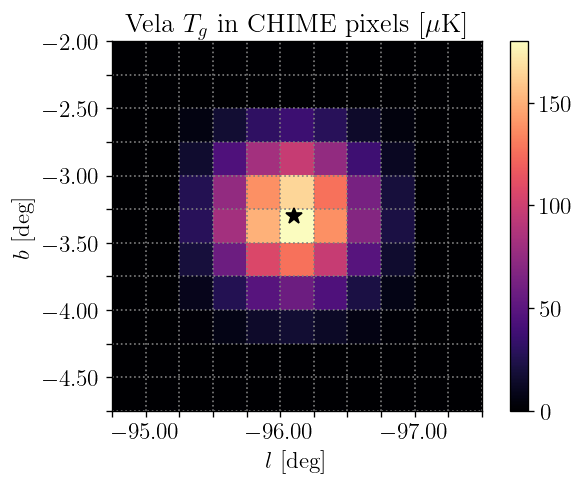

In [118]:
# view Vela
snr = get_snr('Vela', snr_list)

pix_size = CHIME_pixel_size
snr_l = snr.l - 2*np.pi*(snr.l>jnp.pi) # snr_l is in [-pi, pi]
snr_b = snr.b
cpix_il = np.searchsorted(l_edge_s, snr_l) - 1
cpix_ib = np.searchsorted(b_edge_s, snr_b) - 1
cpix_l = l_s[cpix_il]
cpix_b = b_s[cpix_ib]
r = 5
l_st = cpix_l - r*pix_size - 1/2*pix_size
l_ed = cpix_l + r*pix_size + 1/2*pix_size
b_st = cpix_b - r*pix_size - 1/2*pix_size
b_ed = cpix_b + r*pix_size + 1/2*pix_size

z = 1e6 * add_snr_to_map( np.zeros_like(sig_temp_map), get_snr('Vela', snr_list), 408 )

fig, ax = plt.subplots()

im = ax.imshow(np.flip(z[cpix_ib-r:cpix_ib+r+1,cpix_il-r:cpix_il+r+1]),
          extent=(l_ed/deg, l_st/deg, b_st/deg, b_ed/deg), cmap='magma')
ax.plot([snr_l/deg], [snr_b/deg], color='k', marker='*', ms=10)
ax.set(xticks=np.linspace(l_st/deg, l_ed/deg, 2*r+2),
       yticks=np.linspace(b_st/deg, b_ed/deg, 2*r+2))
fig.canvas.draw()
xtl = [(xl.get_text() if i%4==2 else '') for i, xl in enumerate(ax.get_xticklabels())]
ax.set_xticklabels(xtl)
ytl = [(yl.get_text() if i%2==1 else '') for i, yl in enumerate(ax.get_yticklabels())]
ax.set_yticklabels(ytl)
ax.grid(color='gray', linestyle=':', linewidth=1)
ax.set(title=r'Vela $T_g$ in CHIME pixels [$\mu$K]', xlabel=r'$l$ [deg]', ylabel=r'$b$ [deg]')
fig.colorbar(im, ax=ax);

In [119]:
tot_temp_map_wsnr = tot_temp_map[B_scheme].copy()
for snr in tqdm(snr_list):
    add_snr_to_map(tot_temp_map_wsnr, snr, nu_haslam, in_place=True)

  0%|          | 0/102 [00:00<?, ?it/s]

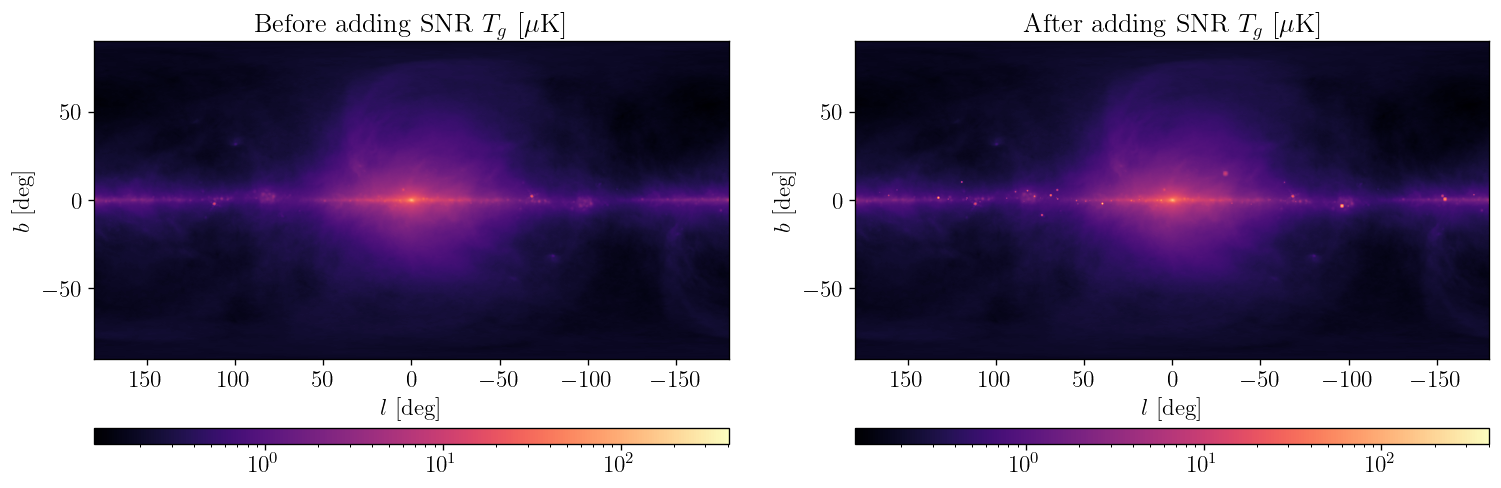

In [120]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))

z0 = tot_temp_map[B_scheme] * 1e6
z1 = tot_temp_map_wsnr * 1e6
im0 = axs[0].imshow(np.flip(z0), cmap='magma', extent=(180, -180, -90, 90),
                    norm=mpl.colors.LogNorm(np.min(z1), np.max(z1)))
im1 = axs[1].imshow(np.flip(z1), cmap='magma', extent=(180, -180, -90, 90),
                    norm=mpl.colors.LogNorm(np.min(z1), np.max(z1)))
axs[0].set(title=r'Before adding SNR $T_g$ [$\mu$K]', xlabel=r'$l$ [deg]', ylabel=r'$b$ [deg]')
axs[1].set(title=r'After adding SNR $T_g$ [$\mu$K]', xlabel=r'$l$ [deg]', ylabel=r'$b$ [deg]')
fig.colorbar(im0, ax=axs[0], orientation='horizontal', aspect=40)
fig.colorbar(im1, ax=axs[1], orientation='horizontal', aspect=40);

## 9. Frequency dependence with SNR

In [121]:
tot_temp_map = {}
B_schemes = ['ASR_H', 'BS_H']
for B_scheme in B_schemes:
    tot_temp_map[B_scheme] = np.load(f'{INTM_DIR}/tot_temp_map_{B_scheme}.npy')
haslam_dsds_map = np.load(f'{INTM_DIR}/haslam_dsds_map.npy')
exposure_map = np.load(f'{INTM_DIR}/exposure_map.npy')

snr_list = pickle.load(open('../data/SNR/snrlist.p', 'rb'))

In [122]:
freq_s = np.linspace(400, 800, 30)
tot_SNR_s = {}
for B_scheme in B_schemes:
    tot_SNR_s[B_scheme] = np.zeros_like(freq_s)
    tot_SNR_s[B_scheme+'_wsnr'] = np.zeros_like(freq_s)
    
beta = -2.55

for i, freq in enumerate(tqdm(freq_s)):
    for B_scheme in B_schemes:
        # without SNR
        sig_temp_map = tot_temp_map[B_scheme] * (freq/nu_haslam)**(beta-1)
        bkg_temp_map = haslam_dsds_map * (freq/nu_haslam)**(beta) + 50
        SNR_map = sig_temp_map * np.sqrt(2*dnu(freq)*1e6*exposure_map*n_day) / bkg_temp_map
        tot_SNR_s[B_scheme][i] = np.sqrt(np.sum(SNR_map**2))
        # with SNR
        for snr in snr_list:
            add_snr_to_map(sig_temp_map, snr, freq, in_place=True)
        SNR_map = sig_temp_map * np.sqrt(2*dnu(freq)*1e6*exposure_map*n_day) / bkg_temp_map
        tot_SNR_s[B_scheme+'_wsnr'][i] = np.sqrt(np.sum(SNR_map**2))

  0%|          | 0/30 [00:00<?, ?it/s]

recalculated


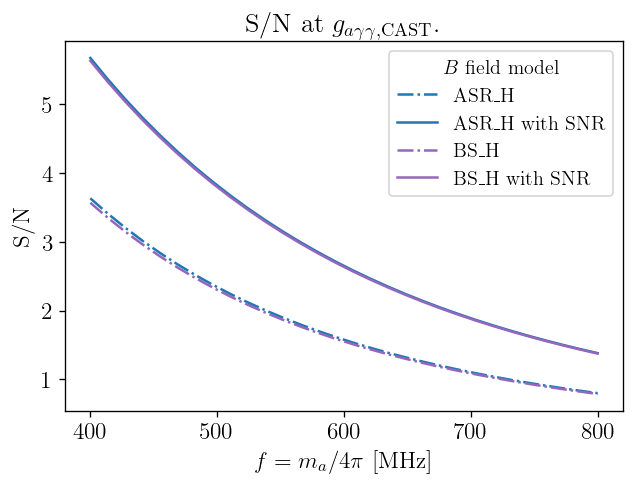

In [126]:
fig, ax = plt.subplots(figsize=(6, 4))

colors = [['tab:blue', 'tab:purple'], ['tab:blue', 'tab:purple']]

for i, B_scheme in enumerate(B_schemes):
    ax.plot(freq_s, tot_SNR_s[B_scheme], '-.', label=B_scheme, c=colors[0][i])
    ax.plot(freq_s, tot_SNR_s[B_scheme+'_wsnr'], label=B_scheme+' with SNR', c=colors[1][i])
ax.set(xlabel=r'$f=m_a/4\pi$ [MHz]', ylabel='S/N',
       title=r'S/N at $g_{a\gamma\gamma,\mathrm{CAST}}$.')
ax.legend(title=r'$B$ field model');